In [1]:
import platform

global systemDivide
global RecursionBorder
RecursionBorder = 20_000

if platform.platform().split('-')[0] == 'macOS':
    systemDivide = '/'
else:
    systemDivide = '\\'

import sys
import threading

threading.stack_size(2**27)
sys.setrecursionlimit(10 ** 5)

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.model_selection import ParameterGrid
from sklearn import linear_model

pairName = 'CHFJPY.csv'

inpData = pd.read_csv(f"testData{systemDivide}{pairName}", index_col=1)
# Какие колонки нужны для работы
columns = ['open', 'high', 'low', 'close']
inpData = inpData[columns]
inpData.index = pd.to_datetime(inpData.index)

In [3]:
def create_strategy_config(params):
    """
    Создает удобную сетку для дальнейших расчетов
    :param params: начальные init параметры
    :return: словарь из параметров использующийся везде
    """
    capital = 20_000
    slippage = 2
    retParams = {
        # Капитал
        'capital': capital,
        'slippage': slippage,
        # Можно использовать для стоп лоссов и тейков с учетом слипэджа
        'slippagePerCapital': slippage / capital,
        # То какой размах мы будем брать для построения полос Боллинджера. Это и есть X Threshold из файла Евгения
        'yThreshold': round(params['yThreshold'] / 100, 2),
        # Период за который мы строим малую скользяшку
        'rollingMean': None,
        # Период за который мы строим большую скользяшку
        'fatRollingMean': None,
        # Временной барьер, Максимальное время сколько мы можем держать позицию
        'timeBarrier': None,
        # Параметр для определения того что данные MeanReversion/TrendFollowing
        # Используется в VRratio тестах для открытия/удержания позиции
        'varianceRatioFilter': params['varianceRatioFilter'],
        # Сколько времени мы не торгуем после срабатывания стоп лосса
        'restAfterLoss': params['restAfterLoss'],
        # Сколько времени мы не торгуем после закрытия позиции о большую скользяшку
        'restAfterFatProfit' : params['restAfterFatProfit'],
        # Процент стоп лосса
        'stopLossStdMultiplier': round(params['stopLossStdMultiplier'] / 100, 3),
        # Процент тэйк профита
        'takeProfitStdMultiplier': round(params['takeProfitStdMultiplier'] / 100, 3),
        # Нужно чтобы пересчитывать VR границы в автоматическом режиме
        'varianceRatioCarreteParameter': params['varianceRatioCarreteParameter'],
        # Тот период за который мы будем считать Variance Ratio. Те ставя тут к примеру 1500, мы должны будем передавать в функцию
        # VR Ratio 1500 точек данных. Сейчас этот гипермараметр связан с гиперпараметров периода малой скользяшки
        'varianceLookBack': None,
        # Чему будет равен временной лаг Q; Q = varianceLookBack // PARAM + 1
        'varianceRatioCarrete': None,
        # Параметр по которому мы будем искать период полураспада
        'scanHalfTime': int(params['scanHalfTime']),
        #
        'halfToFat': int(params['halfToFat']),
        #
        'halfToLight': int(params['halfToLight']),
        #
        'halfToTime': int(params['halfToTime']),

    }
    return retParams

grid_params = {
    # Оптимизировать !!!
    'yThreshold': [300],
    # Оптимизировать !
    'varianceRatioFilter': [1.0],
    # Оптимизировать !!
    'restAfterLoss': [910],
    # Оптимизировать !
    'restAfterFatProfit' : [250],
    # Оптимизировать !!
    'stopLossStdMultiplier': [820],
    # Оптимизировать !
    'takeProfitStdMultiplier': [920],
    # Оптимизировать !!
    'varianceRatioCarreteParameter': [10],
    # Оптимизировать !!!
    'scanHalfTime': [1500],
    # Оптимизировать 0!
    'halfToFat': [2],
    # Оптимизировать 0!
    'halfToLight': [1],
    # Оптимизировать 0!
    'halfToTime': [1],
    }

grid_params = ParameterGrid(grid_params)
grid_params = pd.DataFrame(grid_params).sample(frac=1, random_state=9).reset_index(drop=True)
create_strategy_config(grid_params.iloc[0])

{'capital': 20000,
 'slippage': 2,
 'slippagePerCapital': 0.0001,
 'yThreshold': 3.0,
 'rollingMean': None,
 'fatRollingMean': None,
 'timeBarrier': None,
 'varianceRatioFilter': 1.0,
 'restAfterLoss': 910.0,
 'restAfterFatProfit': 250.0,
 'stopLossStdMultiplier': 8.2,
 'takeProfitStdMultiplier': 9.2,
 'varianceRatioCarreteParameter': 10.0,
 'varianceLookBack': None,
 'varianceRatioCarrete': None,
 'scanHalfTime': 1500,
 'halfToFat': 2,
 'halfToLight': 1,
 'halfToTime': 1}

In [29]:
def cook_data(df: pd.DataFrame, params) -> pd.DataFrame:
    """
    Подготавливает данные для дальнейшего рассчета стратегии.
    :param df: должен быть open, close, low, high
    :param params: список параметров из create_grid
    :return: данные с полосами Болинджера + логарифмы + возвраты
    """
    df['rollMean'] = df['open'].rolling(window=params['rollingMean']).mean()
    df['rollingStd'] = df['open'].rolling(window=params['rollingMean']).std()
    df['fatMean'] = df['open'].rolling(window=params['fatRollingMean']).mean()
    df['logOpenPrice'] = np.log(df['open'])
    df['retOpenPrice'] = df['logOpenPrice'].diff()
    return df.iloc[1:]
def get_half_time(openTuple: pd.Series) -> float:
    df_open = openTuple.to_frame()
    df_lag = df_open.shift(1)
    df_delta = df_open - df_lag
    linear_regression_model = linear_model.LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta), 1)
    df_lag = df_lag.values.reshape(len(df_lag), 1)
    linear_regression_model.fit(df_lag[1:], df_delta[1:])
    half_life = -np.log(2) / linear_regression_model.coef_.item()
    return half_life

def variance_ratio(logTuple: tuple, retTuple: tuple, params: dict) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    buffer_size = len(retTuple)
    means = (1 / buffer_size) * np.sum(retTuple)
    # сдвиг во времени q
    m = params['varianceRatioCarrete'] * (buffer_size - params['varianceRatioCarrete'] + 1 ) * (1 - (params['varianceRatioCarrete'] / buffer_size))
    sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
    subtract_returns = np.subtract(logTuple, np.roll(logTuple, params['varianceRatioCarrete']))[params['varianceRatioCarrete']:]
    _buff_ = np.sum(np.square(subtract_returns - params['varianceRatioCarrete'] * means))
    try:
        sigma_b = (1 / m) * _buff_
    except ZeroDivisionError:
        return False

    result = (sigma_b / sigma_a)
    if result < params['varianceRatioFilter']:
        return True
    else:
        return False

def reverse_variance_ratio(preComputed,params: dict, timeBorderCounter: int) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    retTuple = preComputed["retOpenPrice"]
    logTuple = preComputed["logOpenPrice"]
    if timeBorderCounter < params["varianceLookBack"]:
        buffer_size = len(retTuple)
        means = (1 / buffer_size) * np.sum(retTuple)
        # сдвиг во времени q
        m = timeBorderCounter * (buffer_size - timeBorderCounter + 1 ) * (1 - (timeBorderCounter / buffer_size))
        sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
        subtract_returns = np.subtract(logTuple, np.roll(logTuple, timeBorderCounter))[timeBorderCounter:]
        _buff_ = np.sum(np.square(subtract_returns - timeBorderCounter * means))
        sigma_b = (1 / m) * _buff_
        result = (sigma_b / sigma_a)
        if result > params['varianceRatioFilter']:
            return True
        else:
            return False
    else:
        return False

def calculate_max_drawdown(PNL_SERIES, dollars=True):
    """
    solution by Marco de Prado
    :param PNL_SERIES:
    :param dollars:
    :return:
    """
    dropout_df = PNL_SERIES.to_frame('pnl')
    dropout_df['hwm'] = dropout_df.expanding().max()
    df0 = dropout_df.groupby('hwm').min().reset_index()
    df0.columns = ['hwm', 'min']
    df0 = df0[df0['hwm'] > df0['min']]
    if dollars:
        dd = df0['hwm'] - df0['min']
    else:
        dd = df0['min'] / df0['hwm']

    return max(dd)

def open_position(position, dataFrame, params, reqCounter, preComputed):
    TRIGGER = False
    localParams = params.copy()
    openDict = {
        'typeOperation': None,
        'position': None,
        'openPrice': None,
        'openIndex': None,
        'stopLossBorder': None,
        'takeProfitBorder': None
    }
    if reqCounter > RecursionBorder:
        return position

    # Получить время полураспада для генерации параметров сделки
    half_time = int(get_half_time(dataFrame.close[position-params['scanHalfTime']:position]))
    if (half_time > params['scanHalfTime']) or (half_time < 0):
        return open_position(position=position+1, dataFrame=dataFrame, params=params, reqCounter=reqCounter+1, preComputed=preComputed)

    localParams["rollingMean"] = half_time
    localParams["fatRollingMean"] = int(params['halfToFat'] * half_time)
    localParams["timeBarrier"] = int(half_time * params['halfToTime'])
    localParams["varianceLookBack"] = int(half_time * params['halfToFat'])
    localParams["varianceRatioCarrete"] = int((half_time * params['halfToFat']) // params['varianceRatioCarreteParameter']) + 1

    # Считаем локальные барьеры открытия сделки
    bands_roll = dataFrame.open.iloc[position-half_time:position].rolling(half_time)
    bands_mean = bands_roll.mean().iloc[-1]
    bands_std = bands_roll.std().iloc[-1]
    low_band = round(bands_mean - bands_std * params['yThreshold'],3)
    high_band = round(bands_mean + bands_std * params['yThreshold'],3)

    if (dataFrame.open[position] > low_band) and (dataFrame.low[position] < low_band):
        # Если это так, то убеждаемся что можем открыть сделку проводя тест
        # VR_RATIO (LOOKBACK={HYPERPARAMETER}, time_laq===q={HYPERPARAMETER})
        if variance_ratio(logTuple=preComputed["logTuple"][position - localParams['varianceLookBack']:position],
                      retTuple=preComputed["retTuple"][position - localParams['varianceLookBack']:position],params=localParams):
            # Формируем удобочитаемый тип return функции
            openDict['typeOperation'] = 'BUY'
            openDict['position'] = round(params['capital'] / low_band,3)
            openDict['openPrice'] = low_band
            openDict['openIndex'] = position
            openDict['stopLossBorder'] = round(low_band - params['stopLossStdMultiplier'] * bands_std,3)
            openDict['takeProfitBorder'] = round(low_band + params['takeProfitStdMultiplier'] * bands_std,3)
            LOGIC_BOOL = True
            return {'openDict': openDict, 'params': localParams}

    elif (dataFrame.open[position] < high_band) and (dataFrame.high[position] > high_band):
        # Если это так, то убеждаемся что можем открыть сделку проводя тест
        # VR_RATIO (LOOKBACK={HYPERPARAMETER}, time_laq===q={HYPERPARAMETER})
        if variance_ratio(logTuple=preComputed["logTuple"][position - localParams['varianceLookBack']:position],
                      retTuple=preComputed["retTuple"][position - localParams['varianceLookBack']:position],params=localParams):
            # Формируем удобочитаемый тип return функции
            openDict['typeOperation'] = 'SELL'
            openDict['position'] = -1 * (params['capital'] / high_band)
            openDict['openPrice'] = high_band
            openDict['openIndex'] = position
            openDict['stopLossBorder'] = round(high_band + params['stopLossStdMultiplier'] * bands_std,3)
            openDict['takeProfitBorder'] = round(high_band - params['takeProfitStdMultiplier'] * bands_std,3)
            LOGIC_BOOL = True
            return {'openDict': openDict, 'params': localParams}

    # В случае, если сделку открыть не получилось, переходим к следующей точке. Вывод - пока что сделку не получилось
    # В real-time это является аналогом ожидания до появления следующих данных и повторения проверки на открытие уже на них
    if not TRIGGER:
        return open_position(position=position+1, dataFrame=dataFrame, params=params, reqCounter=reqCounter+1, preComputed=preComputed)

def close_position(position, openDict, dataFrame, localParams, reqCounter, preComputed, borderCounter, indicatorVR):
    TRIGGER = False
    if reqCounter > RecursionBorder:
        return [position, localParams, borderCounter, indicatorVR]

    if borderCounter >= localParams['timeBarrier']:
        return {'typeHolding': 'endPeriod', 'closePrice': dataFrame.open[position+1],
                        'closeIndex': position+1}

    elif openDict['typeOperation'] == 'BUY':
        # Стоп лосс условие
        if (dataFrame.open[position] > openDict['stopLossBorder']) and (dataFrame.low[position] < openDict['stopLossBorder']):
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': position + localParams['restAfterLoss']}
        if dataFrame.open[position] < openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': dataFrame.open[position],
                        'closeIndex': position + localParams['restAfterLoss']}
        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой. Причина этого такая же как для open_position
        # Читай в чем суть - выше!
        elif (dataFrame.open[position] < preComputed["rollMean"][position]) and (not indicatorVR):
            # Проверяем что можно закрыть лонг о пересечение с малой скользящей
            if dataFrame.high[position] > preComputed["rollMean"][position]:
                # Проверяем можно ли продолжить удержание позиции. Делаем это через VariacneRatio за какой-то период
                # arrowIndex - params['varianceLookBack'], где varianceLookBack - гиперпараметр стратегии.
                # Временной лаг Q для VARIANCE_RATIO определяется как время что мы находимся в позиции
                # Если VarianceRatio показывает что данные стали TrendFollowing - мы меняем режим стратегии на попытку закерыться
                # О скользящее среднее за больший период. Так мы получим большую прибыль
                if preComputed["rollMean"][position] < preComputed["fatMean"][position]:
                    if not reverse_variance_ratio(preComputed=preComputed,
                                      params=localParams, timeBorderCounter=borderCounter+1):
                        #   Local Trend Following recursion
                        return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                              openDict=openDict, localParams=localParams, preComputed=preComputed,
                                              borderCounter=borderCounter+1, indicatorVR=True)

                    else:
                        # Если VR RATIO не показал возможность попытаться закрыться о большую скользяшку, то закрываемся
                        # о малую
                        return {'typeHolding': 'lightCross', 'closePrice': preComputed["rollMean"][position],
                                'closeIndex': position }
                        pass

                else:
                    # Может быть так, что скольщяшее среднее за больший период находится выше чем скользящее за малый период
                    # Если учесть что мы торгуем на тех инструментах что показывают большую склонность к meanReversion
                    # такая ситуцация говорит нам что нужно как можно скорей сбрасывать позицию.
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': preComputed["rollMean"][position],
                                'closeIndex': position + localParams['restAfterFatProfit']}

        # Определяет режим работы в случае альтернативной стратегии на которую мы переключаеся в случае выполнения каких-то условий
        if indicatorVR:
            # Аналогично тому что было раньше
            if dataFrame.open[position] < preComputed["fatMean"][position]:
                # Аналогично тому что было раньше
                if dataFrame.high[position] > preComputed["fatMean"][position]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': preComputed["fatMean"][position],
                            'closeIndex': position}
                # Даем возможность переключить режим стратегии снова на нулевой. Делаем это если данные снова начали показывать
                # склонность к meanReversion
                # if variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],
                #       retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
                #     indicatorVR = False
                # ANOTHER LOGIC
                # if not reverse_variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],
                #       retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],
                #                           params=params, timeBorderCounter=timeBorderCounter):
                #     indicatorVR = False

    if not TRIGGER:
        # Trailing StopLoss
        if openDict['typeOperation'] == 'BUY':
            delta = dataFrame.open[position] - dataFrame.open[position-1]
            if delta > 0:
                openDict['stopLossBorder'] = openDict['stopLossBorder'] + delta
        if openDict['typeOperation'] == 'SELL':
            delta = dataFrame.open[position] - dataFrame.open[position-1]
            if delta < 0:
                openDict['stopLossBorder'] = openDict['stopLossBorder'] - delta

        return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                openDict=openDict, localParams=localParams, preComputed=preComputed,
                                  borderCounter=borderCounter+1, indicatorVR=indicatorVR)

def _estimator(dataFrame, gridParams: dict):
    statistics = list()

    params = gridParams.copy()
    # Указатель в данных. Умножено на 2 - из предположения что период большой скользяшки больше малой в 2 раза
    POS = params['scanHalfTime'] * params['halfToFat']
    while POS < 500_000:
        preComputed = {'logTuple': np.log(dataFrame.open.iloc[POS - int(max(params['scanHalfTime'] * params['halfToFat'], 0)):
                                                POS + int(max(RecursionBorder, int(params['scanHalfTime'] * params['halfToTime'])))])}
        preComputed['retTuple'] = preComputed['logTuple'].diff()[1:]
        preComputed['logTuple'] = preComputed['logTuple'][1:]

        openPosition = 0
        while type(openPosition) != dict:
            openPosition = open_position(position=int(params['scanHalfTime'] * params['halfToFat']),
                                         dataFrame=dataFrame.iloc[POS - int(max(params['scanHalfTime'] * params['halfToFat'], 0)):
                                                POS + int(max(RecursionBorder, int(params['scanHalfTime'] * params['halfToTime'])))],
                                                 params=params, reqCounter=0, preComputed=preComputed)
        print(openPosition)
        openDict = openPosition['openDict']
        POS += openDict['openIndex']
        localParameters = openPosition['params']
        closePosition = 0
        preComputed = cook_data(dataFrame.copy().iloc[POS - 1
                                               - int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean'])):
                                               POS + int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean'],  RecursionBorder))], params=localParameters)

        closePosition = 0
        indicatorVR = False
        while type(closePosition) != dict:
            closePosition = close_position(position=int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean'])), openDict=openDict,
                                           dataFrame=dataFrame.copy().iloc[POS
                                               - int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean'])):
                                               POS + int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean'],  RecursionBorder))],
                                           localParams=localParameters, reqCounter=0, preComputed=preComputed, borderCounter=0,
                                           indicatorVR=indicatorVR)
            if type(closePosition) == list:
                indicatorVR = closePosition[3]
                closePosition = closePosition[0]
                borderCounter = closePosition[2]
                POS += closePosition[0]

        closeDict = closePosition
        POS += int(closeDict['closeIndex'])
        statistics.append({**openDict, **closeDict})

    return statistics
parametersGrid = create_strategy_config(grid_params.iloc[0])
stat = _estimator(inpData.copy(), gridParams=parametersGrid)

{'openDict': {'typeOperation': 'BUY', 'position': 177.324, 'openPrice': 112.788, 'openIndex': 3044, 'stopLossBorder': 112.629, 'takeProfitBorder': 112.966}, 'params': {'capital': 20000, 'slippage': 2, 'slippagePerCapital': 0.0001, 'yThreshold': 3.0, 'rollingMean': 151, 'fatRollingMean': 302, 'timeBarrier': 151, 'varianceRatioFilter': 1.0, 'restAfterLoss': 910.0, 'restAfterFatProfit': 250.0, 'stopLossStdMultiplier': 8.2, 'takeProfitStdMultiplier': 9.2, 'varianceRatioCarreteParameter': 10.0, 'varianceLookBack': 302, 'varianceRatioCarrete': 31, 'scanHalfTime': 1500, 'halfToFat': 2, 'halfToLight': 1, 'halfToTime': 1}}
{'openDict': {'typeOperation': 'BUY', 'position': 176.435, 'openPrice': 113.356, 'openIndex': 3164, 'stopLossBorder': 113.182, 'takeProfitBorder': 113.551}, 'params': {'capital': 20000, 'slippage': 2, 'slippagePerCapital': 0.0001, 'yThreshold': 3.0, 'rollingMean': 202, 'fatRollingMean': 404, 'timeBarrier': 202, 'varianceRatioFilter': 1.0, 'restAfterLoss': 910.0, 'restAfterFat

In [30]:
pd.DataFrame(stat)

,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex
0,BUY,177.324000,112.788,3044,113.040,112.966,stopLoss,113.040000,1302.0
1,BUY,176.435000,113.356,3164,113.182,113.551,stopLoss,112.814000,1314.0
2,BUY,177.439000,112.715,3056,112.673,113.245,fatExtraProfit,112.737935,271.0
3,BUY,177.413000,112.731,3239,112.635,112.839,lightCrossEmergent,113.466643,364.0
4,SELL,-176.404177,113.376,3142,113.813,113.145,endPeriod,113.618000,196.0
...,...,...,...,...,...,...,...,...,...
120,SELL,-177.799904,112.486,3638,115.444,111.741,endPeriod,112.330000,928.0
121,SELL,-178.116595,112.286,3057,114.306,112.166,endPeriod,110.157000,250.0
122,BUY,182.437000,109.627,3084,111.365,112.361,stopLoss,111.363000,2394.0
123,SELL,-177.673543,112.566,3088,118.401,110.989,endPeriod,111.508000,871.0


In [31]:
copy_df = pd.DataFrame(stat)
copy_df.loc[copy_df.typeHolding == 'stopLoss', 'closeIndex'] = copy_df[copy_df.typeHolding == 'stopLoss']['closeIndex'] = copy_df[copy_df.typeHolding == 'stopLoss']['closeIndex'] - create_strategy_config(grid_params.iloc[0])["restAfterLoss"]
copy_df['profit'] = (copy_df["position"] * (copy_df["closePrice"] - copy_df["openPrice"]) - parametersGrid['slippage'] if (copy_df["typeOperation"] == 'BUY').bool else abs(copy_df["position"]) * (copy_df["openPrice"] - copy_df["closePrice"]) - parametersGrid['slippage'])
print('Total pnl:', round(copy_df.profit.cumsum().iloc[-1], 2))
copy_df.groupby(by='typeHolding').describe()


Total pnl: 731.5


/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_969/53328544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df.loc[copy_df.typeHolding == 'stopLoss', 'closeIndex'] = copy_df[copy_df.typeHolding == 'stopLoss']['closeIndex'] = copy_df[copy_df.typeHolding == 'stopLoss']['closeIndex'] - create_strategy_config(grid_params.iloc[0])["restAfterLoss"]


position                                                 \
                      count        mean        std         min         25%   
typeHolding                                                                  
endPeriod              74.0 -161.281995  82.761551 -185.521873 -182.576707   
fatExtraProfit          6.0  181.213667   2.908778  177.439000  178.966750   
lightCrossEmergent     15.0  182.270933   2.544641  177.413000  180.861000   
stopLoss               30.0  180.363500   3.122231  175.180000  177.882750   

                                                   openPrice              ...  \
                           50%        75%      max     count        mean  ...   
typeHolding                                                               ...   
endPeriod          -181.609333 -178.23089  184.267      74.0  110.519703  ...   
fatExtraProfit      181.499000  183.69675  184.293       6.0  110.390667  ...   
lightCrossEmergent  182.869000  184.07500  186.359      15.0  109.746867  ...   
stopLoss            180.956000  182.49325  186.412      30.0  110.919400  ...   

                   closeIndex         profit                         \
                          75%     max  count       mean         std   
typeHolding                                                           
endPeriod               619.0  2869.0   74.0  15.300370  131.640507   
fatExtraProfit          530.5  1003.0    6.0  56.049239   48.126526   
lightCrossEmergent      756.0  1193.0   15.0  63.803809   50.626366   
stopLoss                702.0  2934.0   30.0 -56.469236  105.242703   

                                                                              
                           min         25%        50%        75%         max  
typeHolding                                                                   
endPeriod          -336.375279  -55.466018   4.647019  62.553037  635.609322  
fatExtraProfit        2.069596   17.706529  54.304831  97.098712  108.745744  
lightCrossEmergent  -11.278750   27.251385  55.297393  95.897444  150.911780  
stopLoss           -211.620113 -111.486463 -67.593411 -32.885420  314.710632  

[4 rows x 64 columns]

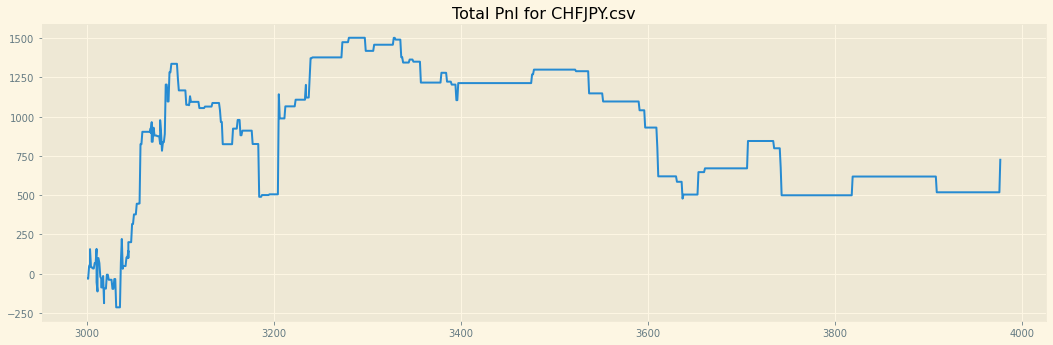

In [32]:
import matplotlib.pylab as plt
copy = copy_df.copy()
copy.index = copy.openIndex
stepDF = pd.DataFrame(index=pd.RangeIndex(min(copy_df.openIndex), max(copy_df.openIndex)))
stepPnl = stepDF.merge(copy, left_index=True, right_index=True, how='outer').profit.replace(np.nan, 0).cumsum()
del copy, stepDF

plt.figure(figsize=(18,12))
plt.style.use('Solarize_Light2')
plt.subplot(2,1,1)
plt.plot(stepPnl)
plt.title(f'Total Pnl for {pairName}')
plt.show()
